<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w1d4_d5_fixes/tutorials/W1D5_Regularization/W1D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Regularization techniques part 2
**Week 1, Day 5: Regularization**

**By Neuromatch Academy**


__Content creators:__ Ravi Teja Konkimalla, Mohitrajhu Lingan Kumaraian, Kevin Machado Gamboa, Kelson Shilling-Scrivo, Lyle Ungar

__Content reviewers:__ Piyush Chauhan, Siwei Bai, Kelson Shilling-Scrivo

__Content editors:__ Roberto Guidotti, Spiros Chavlis

__Production editors:__ Saeed Salehi, Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

1. Regularization as shrinkage of overparameterized models: L1 and L2
2. Regularization by Dropout
3. Regularization by Data Augmentation
4. Perils of Hyper-Parameter Tuning
5. Rethinking generalization

In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/7um6p/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for all videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/7um6p/download).

---
# Setup
Note that some of the code for today can take up to an hour to run. We have therefore "hidden" that code and shown the resulting outputs.


In [2]:
# @title Install dependencies

# @markdown #### **WARNING**: There may be *errors* and *warnings* reported during the installation. However, they should be ignored.

!sudo apt-get install -y xvfb ffmpeg > /dev/null
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

atform = AirtableForm('appn7VdPRseSoMXEG','W1D5_T2', 'https://portal.neuromatchacademy.org/api/redirect/to/a76f99c1-9005-4566-8bcd-bed4e53d21f1')

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/x/xorg-server/xvfb_1.19.6-1ubuntu4.9_amd64.deb  404  Not Found [IP: 91.189.88.152 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


In [3]:
# Imports
import copy
import torch
import random
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR

from tqdm.auto import tqdm
from IPython.display import HTML, display

In [4]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title Loading Animal Faces data
import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `AnimalFaces` dataset...")
name = 'afhq'
fname = f"{name}.zip"
url = f"https://osf.io/kgfvj/download"

if not os.path.exists(fname):
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)

  if os.path.exists(fname):
    with ZipFile(fname, 'r') as zfile:
      zfile.extractall(f".")
      os.remove(fname)

print("Download completed.")

Start downloading and unzipping `AnimalFaces` dataset...
Download completed.


In [6]:
# @title Loading Animal Faces Randomized data
from IPython.display import clear_output

print("Start downloading and unzipping `Randomized AnimalFaces` dataset...")

names = ['afhq_random_32x32', 'afhq_10_32x32']
urls = ["https://osf.io/9sj7p/download",
        "https://osf.io/wvgkq/download"]


for i, name in enumerate(names):
  url = urls[i]
  fname = f"{name}.zip"

  if not os.path.exists(fname):
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)

    if os.path.exists(fname):
      with ZipFile(fname, 'r') as zfile:
        zfile.extractall(f".")
        os.remove(fname)

print("Download completed.")

Start downloading and unzipping `Randomized AnimalFaces` dataset...
Download completed.


In [7]:
# @title Plotting functions


def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def plot_weights(norm, labels, ws, title='Weight Size Measurement'):
  plt.figure(figsize=[8, 6])
  plt.title(title)
  plt.ylabel('Frobenius Norm Value')
  plt.xlabel('Model Layers')
  plt.bar(labels, ws)
  plt.axhline(y=norm,
              linewidth=1,
              color='r',
              ls='--',
              label='Total Model F-Norm')
  plt.legend()
  plt.show()


def visualize_data(dataloader):

  for idx, (data,label) in enumerate(dataloader):
    plt.figure(idx)
    # Choose the datapoint you would like to visualize
    index = 22

    # choose that datapoint using index and permute the dimensions
    # and bring the pixel values between [0,1]
    data = data[index].permute(1, 2, 0) * \
           torch.tensor([0.5, 0.5, 0.5]) + \
           torch.tensor([0.5, 0.5, 0.5])

    # Convert the torch tensor into numpy
    data = data.numpy()

    plt.imshow(data)
    plt.axis(False)
    image_class = classes[label[index].item()]
    print(f'The image belongs to : {image_class}')

  plt.show()

In [8]:
# @title Helper functions

## Network Class - Animal Faces
class AnimalNet(nn.Module):
  def __init__(self):
    super(AnimalNet, self).__init__()
    self.fc1 = nn.Linear(3 * 32 * 32, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 3)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output


# Simple Net
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.fc1 = nn.Linear(1, 300)
    self.fc2 = nn.Linear(300, 500)
    self.fc3 = nn.Linear(500, 1)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    output = self.fc3(x)
    return output


# Network Class - Animal Faces
class BigAnimalNet(nn.Module):
  def __init__(self):
    super(BigAnimalNet, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 124)
    self.fc2 = nn.Linear(124, 64)
    self.fc3 = nn.Linear(64, 3)

  def forward(self, x):
    x = x.view(x.shape[0],-1)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output


def train(args, model, train_loader, optimizer, epoch,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  """
  Trains the current inpur model using the data
  from Train_loader and Updates parameters for a single pass
  """

  device = args['device']
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    # L1 regularization
    if reg_function2 is None and reg_function1 is not None:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model)
    # L2 regularization
    elif reg_function1 is None and reg_function2 is not None:
      loss = criterion(output, target) + args['lambda2']*reg_function2(model)
    # No regularization
    elif reg_function1 is None and reg_function2 is None:
      loss = criterion(output, target)
    # Both L1 and L2 regularizations
    else:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
    loss.backward()
    optimizer.step()

  return model


def test(model, test_loader, loader='Test', criterion=F.nll_loss,
         device='cpu'):
  """
  Tests the current Model
  """
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  def __init__(self):
    super(BigAnimalNet, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 124)
    self.fc2 = nn.Linear(124, 64)
    self.fc3 = nn.Linear(64, 3)

  def forward(self, x):
    x = x.view(x.shape[0],-1)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output
  return 100. * correct / len(test_loader.dataset)


def main(args, model, train_loader, val_loader, test_data,
         reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  """
  Trains the model with train_loader and tests the learned model using val_loader
  """

  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

  val_acc_list, train_acc_list,param_norm_list = [], [], []
  for epoch in tqdm(range(args['epochs'])):
    trained_model = train(args, model, train_loader, optimizer, epoch,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)
    train_acc = test(trained_model, train_loader, loader='Train', device=device)
    val_acc = test(trained_model, val_loader, loader='Val', device=device)
    param_norm = calculate_frobenius_norm(trained_model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    param_norm_list.append(param_norm)

  return val_acc_list, train_acc_list, param_norm_list, model


def calculate_frobenius_norm(model):
    norm = 0.0
    # Sum the square of all parameters
    for name,param in model.named_parameters():
        norm += torch.norm(param).data**2
    # Return a square root of the sum of squares of all the parameters
    return norm**0.5


def early_stopping_main(args, model, train_loader, val_loader, test_data):

  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

  best_acc  = 0.0
  best_epoch = 0

  # Number of successive epochs that you want to wait before stopping training process
  patience = 20

  # Keps track of number of epochs during which the val_acc was less than best_acc
  wait = 0

  val_acc_list, train_acc_list = [], []
  for epoch in tqdm(range(args['epochs'])):
    trained_model = train(args, model, device, train_loader, optimizer, epoch)
    train_acc = test(trained_model, train_loader, loader='Train', device=device)
    val_acc = test(trained_model, val_loader, loader='Val', device=device)
    if (val_acc > best_acc):
      best_acc = val_acc
      best_epoch = epoch
      best_model = copy.deepcopy(trained_model)
      wait = 0
    else:
      wait += 1
    if (wait > patience):
      print(f'early stopped on epoch: {epoch}')
      break
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

  return val_acc_list, train_acc_list, best_model, best_epoch

In [9]:
# @title Set random seed
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [10]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [11]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [12]:
# @title Dataloaders for the Dataset
## Dataloaders for the Dataset
batch_size = 128
classes = ('cat', 'dog', 'wild')

train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)


####################################################
g_seed = torch.Generator()
g_seed.manual_seed(SEED)


##Dataloaders for the  Original Dataset
img_train_data, img_val_data,_ = torch.utils.data.random_split(img_dataset,
                                                               [100, 100, 14430])

#Creating train_loader and Val_loader
train_loader = torch.utils.data.DataLoader(img_train_data,
                                           batch_size=batch_size,
                                           worker_init_fn=seed_worker,
                                           num_workers=2,
                                           generator=g_seed)
val_loader = torch.utils.data.DataLoader(img_val_data,
                                         batch_size=1000,
                                         num_workers=2,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

#creating test dataset
test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)


####################################################

## Dataloaders for the  Random Dataset

# splitting randomized data into training and validation data
data_path = pathlib.Path('.')/'afhq_random_32x32/afhq_random' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
random_img_train_data, random_img_val_data,_ = torch.utils.data.random_split(img_dataset, [100,100,14430])

#Randomized train and validation dataloader
rand_train_loader = torch.utils.data.DataLoader(random_img_train_data,
                                                batch_size=batch_size,
                                                num_workers=2,
                                                worker_init_fn=seed_worker,
                                                generator=g_seed)
rand_val_loader = torch.utils.data.DataLoader(random_img_val_data,
                                              batch_size=1000,
                                              num_workers=2,
                                              worker_init_fn=seed_worker,
                                              generator=g_seed)

####################################################

## Dataloaders for the Partially Random Dataset

# Splitting data between training and validation dataset for partially randomized data
data_path = pathlib.Path('.')/'afhq_10_32x32/afhq_10' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
partially_random_train_data, partially_random_val_data, _ = torch.utils.data.random_split(img_dataset, [100,100,14430])

#Training and Validation loader for partially randomized data
partial_rand_train_loader = torch.utils.data.DataLoader(partially_random_train_data,
                                                        batch_size=batch_size,
                                                        num_workers=2,
                                                        worker_init_fn=seed_worker,
                                                        generator=g_seed)
partial_rand_val_loader = torch.utils.data.DataLoader(partially_random_val_data,
                                                      batch_size=1000,
                                                      num_workers=2,
                                                      worker_init_fn=seed_worker,
                                                      generator=g_seed)

---
# Section 1: L1 and L2 Regularization

*Time estimate: ~30 mins*


In [13]:
# @title Video 1: L1 and L2 regression
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV19h41167H7", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"oQNdloKdysM", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 1: L1 and L2 regression')

display(out)

Some of you might have already come across L1 and L2 regularization before in other courses. L1 and L2 are the most common types of regularization. These update the general cost function by adding another term known as the regularization term.

<br>

\begin{equation}
\text{Cost function} = Loss(\text{e.g., binary cross entropy}) + \text{Regularization term}
\end{equation}

<br>

This regularization term makes the parameters smaller, giving simpler models that will overfit less.

Discuss among your teammates whether the above assumption is good or bad?

## Section 1.1: Unregularized Model

In [14]:
# @markdown #### Dataloaders for Regularization
data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)

# Splitting dataset
reg_train_data, reg_val_data,_ = torch.utils.data.random_split(img_dataset,
                                                               [30, 100, 14500])
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Creating train_loader and Val_loader
reg_train_loader = torch.utils.data.DataLoader(reg_train_data,
                                               batch_size=batch_size,
                                               worker_init_fn=seed_worker,
                                               num_workers=2,
                                               generator=g_seed)
reg_val_loader = torch.utils.data.DataLoader(reg_val_data,
                                             batch_size=1000,
                                             worker_init_fn=seed_worker,
                                             num_workers=2,
                                             generator=g_seed)

Now let's train a model without regularization and keep it aside as our benchmark for this section.

Random seed 2021 has been set.


  0%|          | 0/150 [00:00<?, ?it/s]

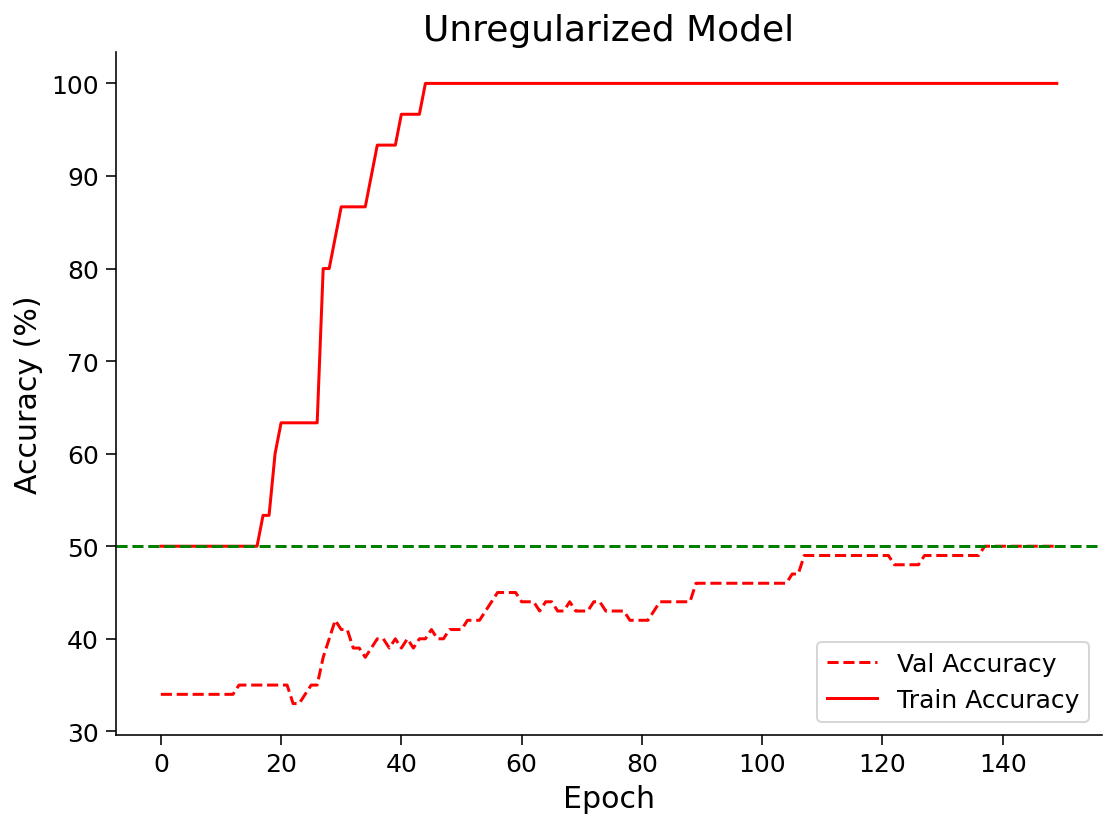

maximum Validation Accuracy reached: 50.0


In [15]:
# Set the arguments
args = {
    'epochs': 150,
    'lr': 5e-3,
    'momentum': 0.99,
    'device': DEVICE,
}

# intialize the model
set_seed(seed=SEED)
model = AnimalNet()

# Train the model
val_acc_unreg, train_acc_unreg, param_norm_unreg, _ = main(args,
                                                           model,
                                                           reg_train_loader,
                                                           reg_val_loader,
                                                           img_test_dataset)

# Train and Test accuracy plot
plt.figure()
plt.plot(val_acc_unreg, label='Val Accuracy', c='red', ls='dashed')
plt.plot(train_acc_unreg, label='Train Accuracy', c='red', ls='solid')
plt.axhline(y=max(val_acc_unreg), c='green', ls='dashed')
plt.title('Unregularized Model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print(f"maximum Validation Accuracy reached: {max(val_acc_unreg)}")

## Section 1.2: L1 Regularization

L1 Regularization (or LASSO$^{\ddagger}$) uses a penalty which is the sum of the absolute value of all the weights in the Deep Learning architecture, resulting in the following loss function ($L$ is the usual Cross-Entropy loss):

\begin{equation}
  L_R = L + \lambda \sum \left| w^{(r)}_{ij} \right|
\end{equation}

where $r$ denotes the layer, and $ij$ the specific weight in that layer.

At a high level, L1 Regularization is similar to L2 Regularization since it leads to smaller weights (you will see the analogy in the next subsection). It results in the following weight update equation when using Stochastic Gradient Descent:

\begin{equation}
  w^{(r)}_{ij}←w^{(r)}_{ij} − \eta \cdot \lambda \cdot \text{sgn}\left(w^{(r)}_{ij}\right)−\eta \frac{\partial L}{\partial w_{ij}^{(r)}} 
\end{equation}

where  $\text{sgn}(\cdot)$ is the sign function, such that

\begin{equation}
\text{sgn}(w) = 
\left\{
  \begin{array}{ll}
  +1 & \mbox{if  } w > 0 \\
  -1 & \mbox{if  } w < 0 \\
  0 & \mbox{if  } w = 0
  \end{array}
\right.
\end{equation}

<br>

$^{\ddagger}$LASSO: Least Absolute Shrinkage and Selection Operator

### Coding Exercise 1.1: L1 Regularization

Write a function that calculates the L1 norm of all the tensors of a PyTorch model.

In [16]:
def l1_reg(model):
  """
    Inputs: Pytorch model
    This function calculates the l1 norm of the all the tensors in the model
  """
  l1 = 0.0
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Complete the l1_reg function")
  ####################################################################
  for param in model.parameters():
    l1 += ...

  return l1

# add event to airtable
atform.add_event('Coding Exercise 1.1: L1 Regularization')

set_seed(seed=SEED)
## uncomment to test
# net = nn.Linear(20, 20)
# print(f"L1 norm of the model: {l1_reg(net)}")

Random seed 2021 has been set.


In [17]:
# to_remove solution
def l1_reg(model):
  """
    Inputs: Pytorch model
    This function calculates the l1 norm of the all the tensors in the model
  """
  l1 = 0.0

  for param in model.parameters():
    l1 += torch.sum(torch.abs(param))

  return l1

# add event to airtable
atform.add_event('Coding Exercise 1.1: L1 Regularization')

set_seed(seed=SEED)
## uncomment to test
net = nn.Linear(20, 20)
print(f"L1 norm of the model: {l1_reg(net)}")

Random seed 2021 has been set.
L1 norm of the model: 48.445133209228516


```
Random seed 2021 has been set.
L1 norm of the model: 48.445133209228516
```

Now, let's train a classifier that uses L1 regularization. Tune the hyperparameter `lambda1` such that the validation accuracy is higher than that of the unregularized model.

Random seed 2021 has been set.


  0%|          | 0/150 [00:00<?, ?it/s]

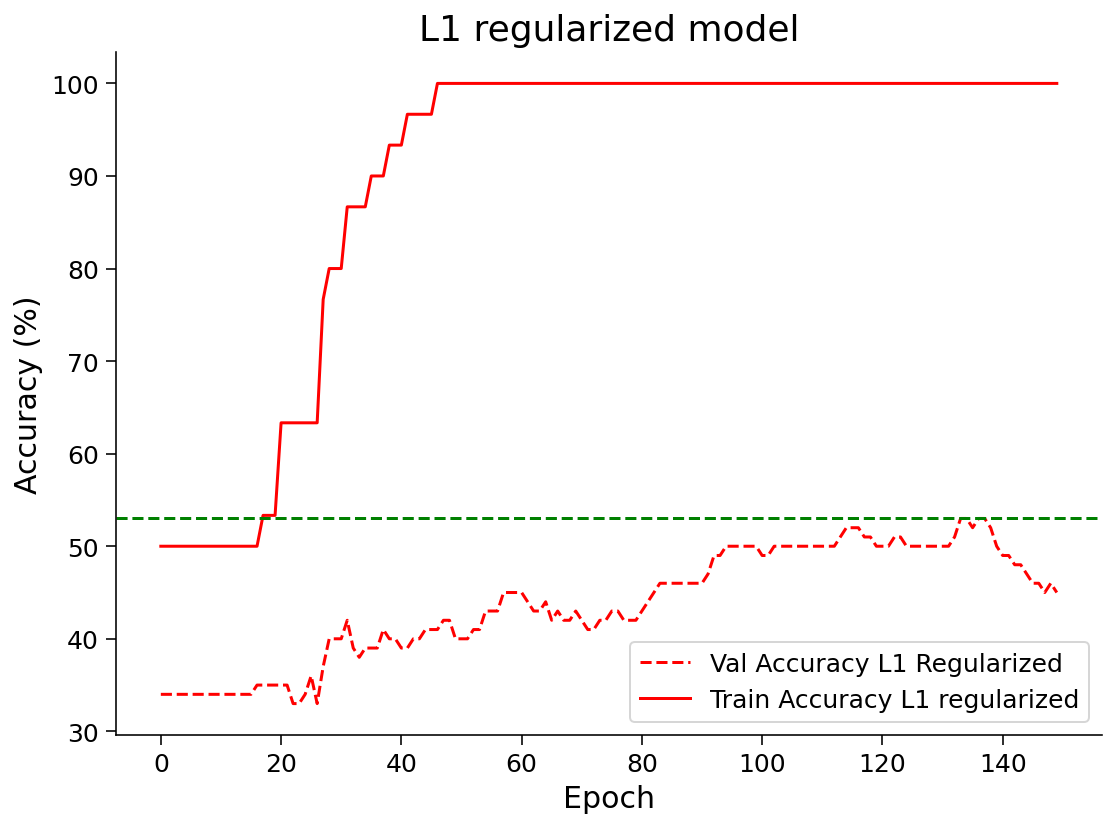

maximum Validation Accuracy reached: 53.0


In [18]:
# Set the arguments
args1 = {
    'test_batch_size': 1000,
    'epochs': 150,
    'lr': 5e-3,
    'momentum': 0.99,
    'device': DEVICE,
    'lambda1': 0.001  # <<<<<<<< Tune the hyperparameter lambda1
}

# intialize the model
set_seed(seed=SEED)
model = AnimalNet()

# Train the model
val_acc_l1reg, train_acc_l1reg, param_norm_l1reg, _ = main(args1,
                                                           model,
                                                           reg_train_loader,
                                                           reg_val_loader,
                                                           img_test_dataset,
                                                           reg_function1=l1_reg)

# Train and Test accuracy plot
plt.figure()
plt.plot(val_acc_l1reg, label='Val Accuracy L1 Regularized',
         c='red', ls='dashed')
plt.plot(train_acc_l1reg, label='Train Accuracy L1 regularized',
         c='red', ls='solid')
plt.axhline(y=max(val_acc_l1reg), c='green', ls='dashed')
plt.title('L1 regularized model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print(f"maximum Validation Accuracy reached: {max(val_acc_l1reg)}")

What value of `lambda1` hyperparameter worked for L1 Regularization?

**Note:** that the $\lambda$ in the equations is the `lambda1` in the code for clarity.

## Section 1.3: L2 / Ridge Regularization

L2 Regularization (or Ridge), also referred to as “Weight Decay”, is widely used. It works by adding a quadratic penalty term to the Cross-Entropy Loss Function $L$, which results in a new Loss Function $L_R$ given by:

\begin{equation}
L_R = L + \lambda \sum \left( w^{(r)}_{ij} \right)^2
\end{equation}

where, again, $r$ superscript denotes the layer, and $ij$ the specific weight in that layer.

To get further insight into L2 Regularization, we investigate its effect on the Gradient Descent based update equations for the weight and bias parameters. Taking the derivative on both sides of the above equation, we obtain

\begin{equation}
\frac{\partial L_R}{\partial w^{(r)}_{ij}}=\frac{\partial L}{\partial w^{(r)}_{ij}} + 2\lambda w^{(r)}_{ij}
\end{equation}

Thus the weight update rule becomes:

\begin{equation}
w^{(r)}_{ij}←w^{(r)}_{ij}−η\frac{\partial L}{\partial w^{(r)}_{ij}}−2 \eta \lambda w^{(r)}_{ij}=(1−2 \eta \lambda)w^{(r)}_{ij} − \eta \frac{\partial L}{\partial w^{(r)}_{ij}}
\end{equation}

where $\eta$ is the learning rate.

### Coding Exercise 1.2: L2 Regularization

Write a function that calculates the L2 norm of all the tensors of a PyTorch model. (What did we call this before?)

In [19]:
def l2_reg(model):

  """
    Inputs: Pytorch model
    This function calculates the l2 norm of the all the tensors in the model
  """

  l2 = 0.0
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Complete the l2_reg function")
  ####################################################################
  for param in model.parameters():
    l2 += ...

  return l2

# add event to airtable
atform.add_event('Coding Exercise 1.2: L2 Regularization')

set_seed(SEED)
## uncomment to test
# net = nn.Linear(20, 20)
# print(f"L2 norm of the model: {l2_reg(net)}")

Random seed 2021 has been set.


In [20]:
# to_remove solution
def l2_reg(model):

  """
    Inputs: Pytorch model
    This function calculates the l2 norm of the all the tensors in the model
  """

  l2 = 0.0
  for param in model.parameters():
    l2 += torch.sum(torch.abs(param)**2)

  return l2

# add event to airtable
atform.add_event('Coding Exercise 1.2: L2 Regularization')

set_seed(SEED)
## uncomment to test
net = nn.Linear(20, 20)
print(f"L2 norm of the model: {l2_reg(net)}")

Random seed 2021 has been set.
L2 norm of the model: 7.328375816345215


```
Random seed 2021 has been set.
L2 norm of the model: 7.328375816345215
```

Now we'll train a classifier that uses L2 regularization. Tune the hyperparameter `lambda2` such that the validation accuracy is higher than that of the unregularized model.

Random seed 2021 has been set.


  0%|          | 0/150 [00:00<?, ?it/s]

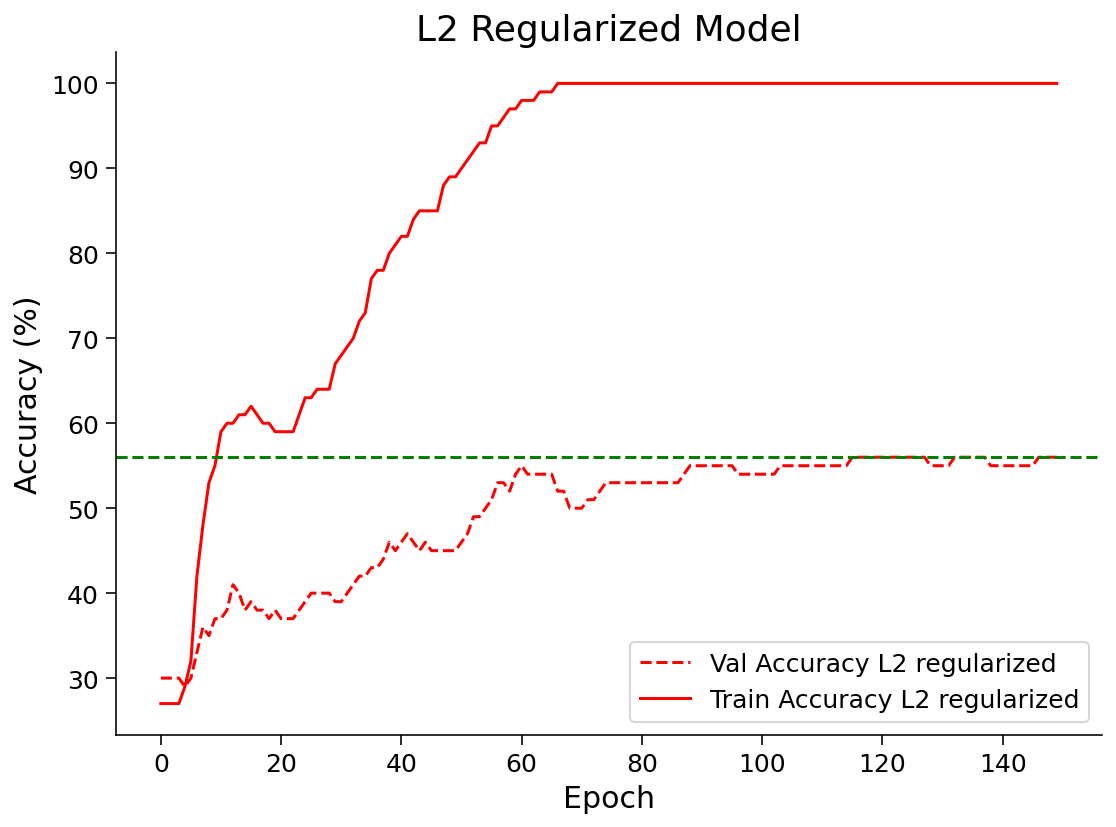

maximum Validation Accuracy reached: 56.0


In [21]:
# Set the arguments
args2 = {
    'test_batch_size': 1000,
    'epochs': 150,
    'lr': 5e-3,
    'momentum': 0.99,
    'device': DEVICE,
    'lambda2': 0.001  # <<<<<<<< Tune the hyperparameter lambda2
}

# intialize the model
set_seed(seed=SEED)
model = AnimalNet()

# Train the model
val_acc_l2reg, train_acc_l2reg, param_norm_l2reg, model = main(args2,
                                                               model,
                                                               train_loader,
                                                               val_loader,
                                                               img_test_dataset,
                                                               reg_function2=l2_reg)

## Train and Test accuracy plot
plt.figure()
plt.plot(val_acc_l2reg, label='Val Accuracy L2 regularized',
         c='red', ls='dashed')
plt.plot(train_acc_l2reg, label='Train Accuracy L2 regularized',
         c='red', ls='solid')
plt.axhline(y=max(val_acc_l2reg), c='green', ls='dashed')
plt.title('L2 Regularized Model')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print(f"maximum Validation Accuracy reached: {max(val_acc_l2reg)}")

What value `lambda2` worked for L2 Regularization?

**Note:** that the $\lambda$ in the equations is the `lambda2` in the code for clarity.

Now, let's run a model with both L1 and L2 regularization terms.

Random seed 2021 has been set.


  0%|          | 0/150 [00:00<?, ?it/s]

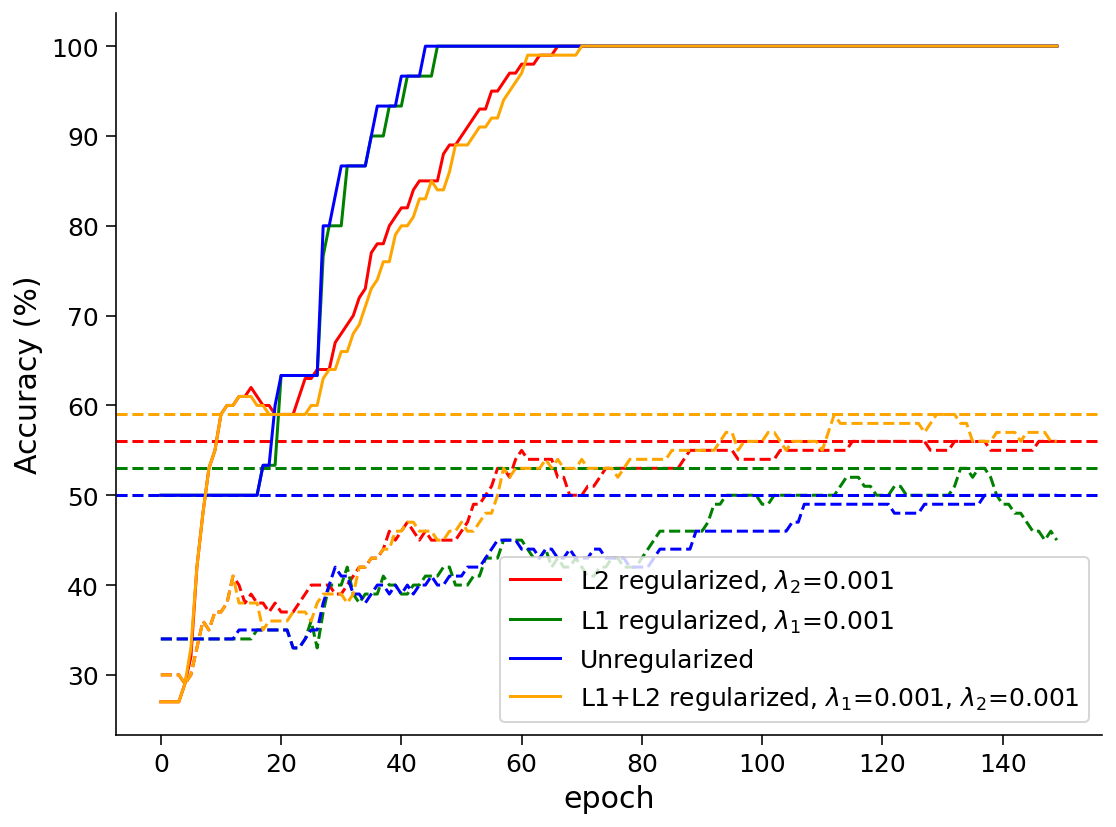

In [22]:
# @markdown Visualize all of them together (Run Me!)

# @markdown `lambda1=0.001` and `lambda2=0.001`

args3 = {
    'test_batch_size': 1000,
    'epochs': 150,
    'lr': 5e-3,
    'momentum': 0.99,
    'device': DEVICE,
    'lambda1': 0.001,
    'lambda2': 0.001
}

# Intialize the model
set_seed(seed=SEED)
model = AnimalNet()
val_acc_l1l2reg, train_acc_l1l2reg, param_norm_l1l2reg, _ = main(args3,
                                                                 model,
                                                                 train_loader,
                                                                 val_loader,
                                                                 img_test_dataset,
                                                                 reg_function1=l1_reg,
                                                                 reg_function2=l2_reg)

plt.figure()

plt.plot(val_acc_l2reg, c='red', ls='dashed')
plt.plot(train_acc_l2reg,
         label=f"L2 regularized, $\lambda_2$={args2['lambda2']}",
         c='red', ls='solid')
plt.axhline(y=max(val_acc_l2reg), c='red', ls='dashed')

plt.plot(val_acc_l1reg, c='green', ls = 'dashed')
plt.plot(train_acc_l1reg,
         label=f"L1 regularized, $\lambda_1$={args1['lambda1']}",
         c='green', ls='solid')
plt.axhline(y=max(val_acc_l1reg), c='green', ls='dashed')

plt.plot(val_acc_unreg, c='blue', ls = 'dashed')
plt.plot(train_acc_unreg,
         label='Unregularized', c='blue', ls='solid')
plt.axhline(y=max(val_acc_unreg), c='blue', ls='dashed')

plt.plot(val_acc_l1l2reg, c='orange', ls='dashed')
plt.plot(train_acc_l1l2reg,
         label=f"L1+L2 regularized, $\lambda_1$={args3['lambda1']}, $\lambda_2$={args3['lambda2']}",
         c='orange', ls='solid')
plt.axhline(y=max(val_acc_l1l2reg), c='orange', ls = 'dashed')

plt.xlabel('epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Now, let's visualize what these different regularizations do to the model's parameters. We observe the effect by computing the size (technically, the Frobenius norm).

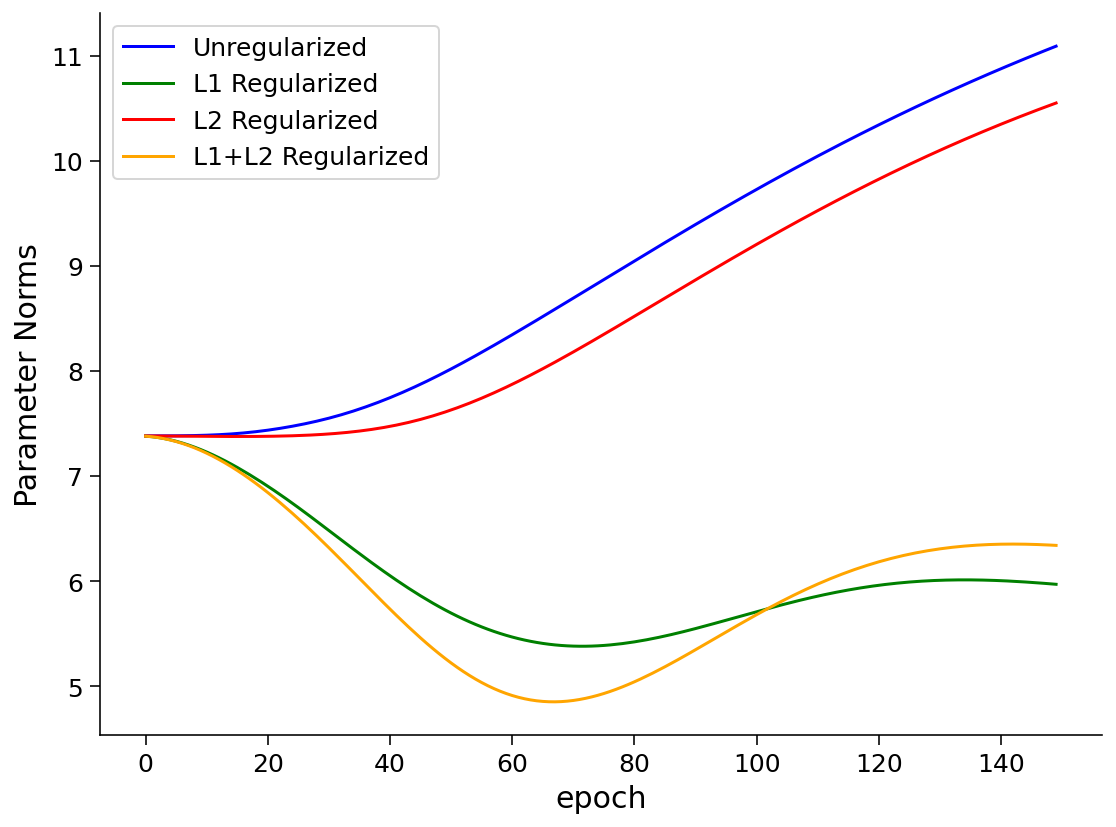

In [23]:
# @markdown #### Visualize Norm of the Models (Train Me!)
plt.figure()
plt.plot(param_norm_unreg, label='Unregularized', c='blue')
plt.plot(param_norm_l1reg, label='L1 Regularized', c='green')
plt.plot(param_norm_l2reg, label='L2 Regularized', c='red')
plt.plot(param_norm_l1l2reg, label='L1+L2 Regularized', c='orange')
plt.xlabel('epoch')
plt.ylabel('Parameter Norms')
plt.legend()
plt.show()

In the above plots, you should have seen that the validation accuracies fluctuate even after the model achieves 100% train accuracy. Thus, the model is still trying to learn something. Why would this be the case?

---
# Section 2: Dropout

*Time estimate: ~25 mins*


In [24]:
# @title Video 2: Dropout
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1gU4y1G7V2", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"UZfUzawej3A", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: Dropout')

display(out)

With Dropout, we literally drop out (zero out) some neurons during training. Throughout the training, the standard dropout zeros out some fraction (usually 50%) of the nodes in each layer, and on each iteration, before calculating the subsequent layer. Randomly selecting different subsets to drop out introduces noise into the process and reduces overfitting.

<br>

<center><img src="https://d2l.ai/_images/dropout2.svg" alt="Dropout" width="600"/></center>

<br>


Now let's revisit the toy dataset we generated above to visualize how the Dropout stabilizes training on a noisy dataset. We will slightly modify the architecture we used above to add dropout layers.

In [25]:
# Network Class - 2D
class NetDropout(nn.Module):
  def __init__(self):
    super(NetDropout, self).__init__()

    self.fc1 = nn.Linear(1, 300)
    self.fc2 = nn.Linear(300, 500)
    self.fc3 = nn.Linear(500, 1)
    # We add two dropout layers
    self.dropout1 = nn.Dropout(0.4)
    self.dropout2 = nn.Dropout(0.2)

  def forward(self, x):
    x = F.leaky_relu(self.dropout1(self.fc1(x)))
    x = F.leaky_relu(self.dropout2(self.fc2(x)))
    output = self.fc3(x)
    return output

In [26]:
# @markdown #### Run to train the default network
set_seed(seed=SEED)
# creating train data
X = torch.rand((10, 1))
X.sort(dim = 0)
Y = 2*X + 2*torch.empty((X.shape[0], 1)).normal_(mean=0, std=1)  # adding small error in the data

X = X.unsqueeze_(1)
Y = Y.unsqueeze_(1)

# creating test dataset
X_test = torch.linspace(0, 1, 40)
X_test = X_test.reshape((40, 1, 1))

# train the network on toy dataset
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
max_epochs = 10000
iters = 0

running_predictions = np.empty((40, (int)(max_epochs/500 + 1)))

train_loss = []
test_loss = []
model_norm = []

for epoch in tqdm(range(max_epochs)):

  #training
  model_norm.append(calculate_frobenius_norm(model))
  model.train()
  optimizer.zero_grad()
  predictions = model(X)
  loss = criterion(predictions,Y)
  loss.backward()
  optimizer.step()

  train_loss.append(loss.data)
  model.eval()
  Y_test = model(X_test)
  loss = criterion(Y_test, 2*X_test)
  test_loss.append(loss.data)

  if (epoch % 500 == 0 or epoch == max_epochs - 1):
    running_predictions[:, iters] = Y_test[:, 0, 0].detach().numpy()
    iters += 1

Random seed 2021 has been set.


  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
# train the network on toy dataset

# Intialize the model
set_seed(seed=SEED)
model = NetDropout()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
max_epochs = 10000
iters = 0

running_predictions_dp = np.empty((40, (int)(max_epochs / 500)))

train_loss_dp = []
test_loss_dp = []
model_norm_dp = []

for epoch in tqdm(range(max_epochs)):

  # training
  model_norm_dp.append(calculate_frobenius_norm(model))
  model.train()
  optimizer.zero_grad()
  predictions = model(X)
  loss = criterion(predictions, Y)
  loss.backward()
  optimizer.step()

  train_loss_dp.append(loss.data)
  model.eval()
  Y_test = model(X_test)
  loss = criterion(Y_test, 2*X_test)
  test_loss_dp.append(loss.data)

  if (epoch % 500 == 0 or epoch == max_epochs):
    running_predictions_dp[:, iters] = Y_test[:, 0, 0].detach().numpy()
    iters += 1

Random seed 2021 has been set.


  0%|          | 0/10000 [00:00<?, ?it/s]

Now that we have finished the training, let's see how the model has evolved over the training process.

In [28]:
# @markdown Animation! (Run Me!)
set_seed(seed=SEED)

fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
def frame(i):
  ax.clear()
  ax.scatter(X[:, 0, :].numpy(), Y[:, 0, :].numpy())
  plot = ax.plot(X_test[:, 0, :].detach().numpy(),
                 running_predictions_dp[:, i])
  title = f"Epoch: {i*500}"
  plt.title(title)
  ax.set_xlabel("X axis")
  ax.set_ylabel("Y axis")
  return plot


anim = animation.FuncAnimation(fig, frame, frames=range(20),
                               blit=False, repeat=False,
                               repeat_delay=10000)
html_anim = HTML(anim.to_html5_video());
plt.close()
display(html_anim)

Random seed 2021 has been set.


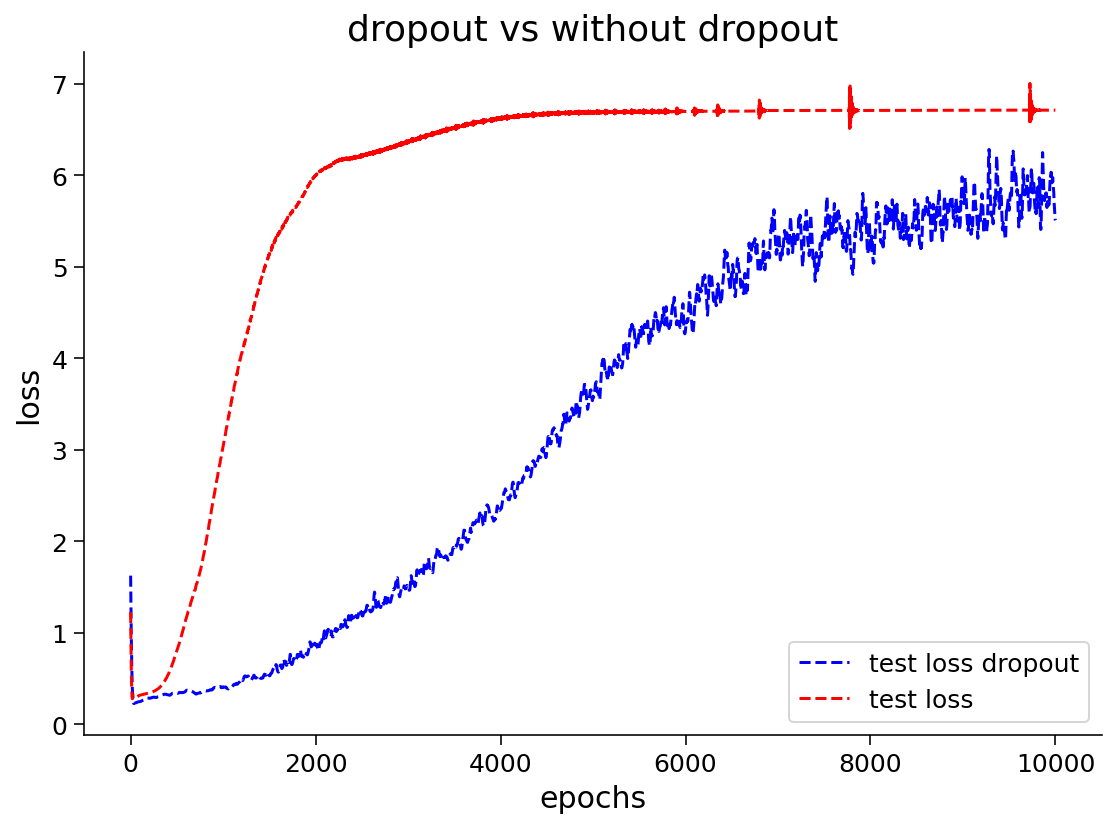

In [29]:
# @markdown Plot the train and test losses with epoch

plt.figure()
plt.plot(test_loss_dp, label='test loss dropout', c='blue', ls='dashed')
plt.plot(test_loss, label='test loss', c='red', ls='dashed')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('dropout vs without dropout')
plt.legend()
plt.show()

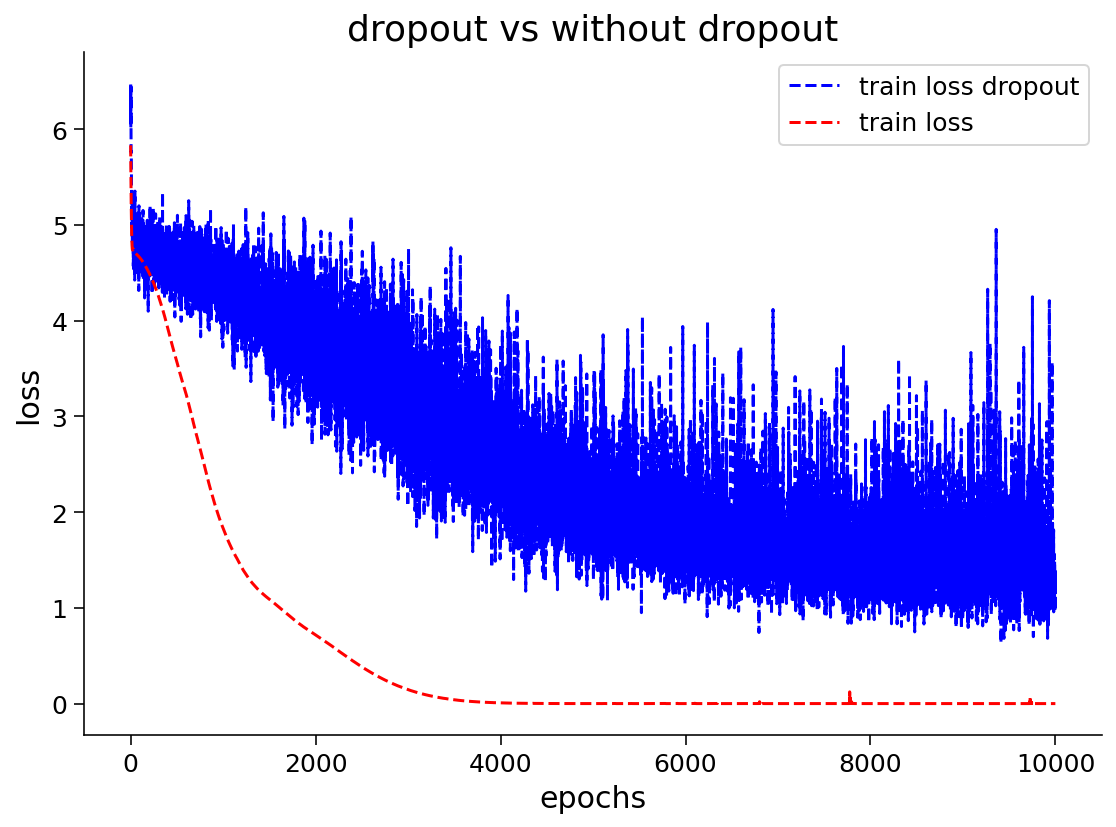

In [30]:
# @markdown Plot the train and test losses with epoch

plt.figure()
plt.plot(train_loss_dp, label='train loss dropout', c='blue', ls='dashed')
plt.plot(train_loss, label='train loss', c='red', ls='dashed')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('dropout vs without dropout')
plt.legend()
plt.show()

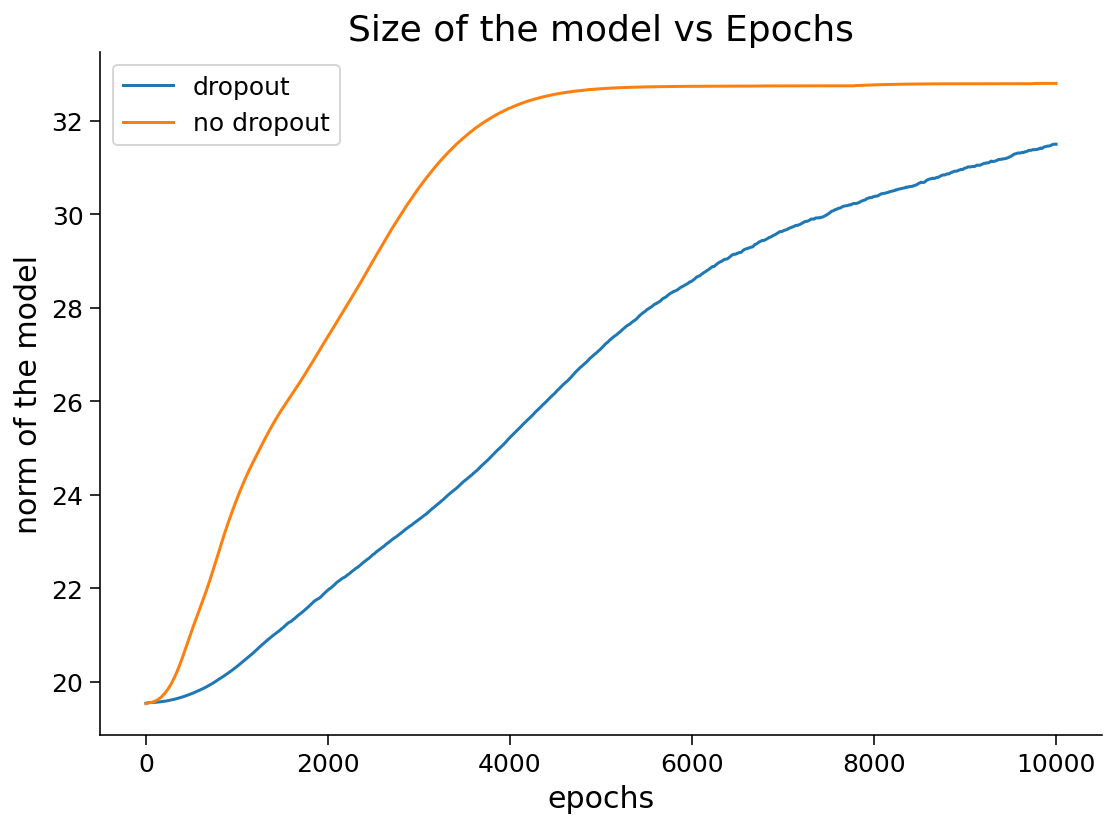

In [31]:
# @markdown Plot model weights with epoch
plt.figure()
plt.plot(model_norm_dp, label='dropout')
plt.plot(model_norm, label='no dropout')
plt.ylabel('norm of the model')
plt.xlabel('epochs')
plt.legend()
plt.title('Size of the model vs Epochs')
plt.show()

Do you think this performed better than the initial model?

## Section 2.1: Dropout Implementation Caveats

* Dropout is used only during training. However, the complete model weights are used during testing, so it is vital to use the `model.eval()` method before testing the model. 

* Dropout reduces the capacity of the model during training, and hence as a general practice, wider networks are used when using dropout. If you are using a dropout with a random probability of 0.5, you might want to double the number of hidden neurons in that layer.

Now, let's see how dropout fares on the “Animal Faces” dataset. We first modify the existing model to include dropout and then train it.

In [32]:
# Network Class - Animal Faces
class AnimalNetDropout(nn.Module):
  def __init__(self):
    super(AnimalNetDropout, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 248)
    self.fc2 = nn.Linear(248, 210)
    self.fc3 = nn.Linear(210, 3)
    self.dropout1 = nn.Dropout(p=0.5)
    self.dropout2 = nn.Dropout(p=0.3)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = F.leaky_relu(self.dropout1(self.fc1(x)))
    x = F.leaky_relu(self.dropout2(self.fc2(x)))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

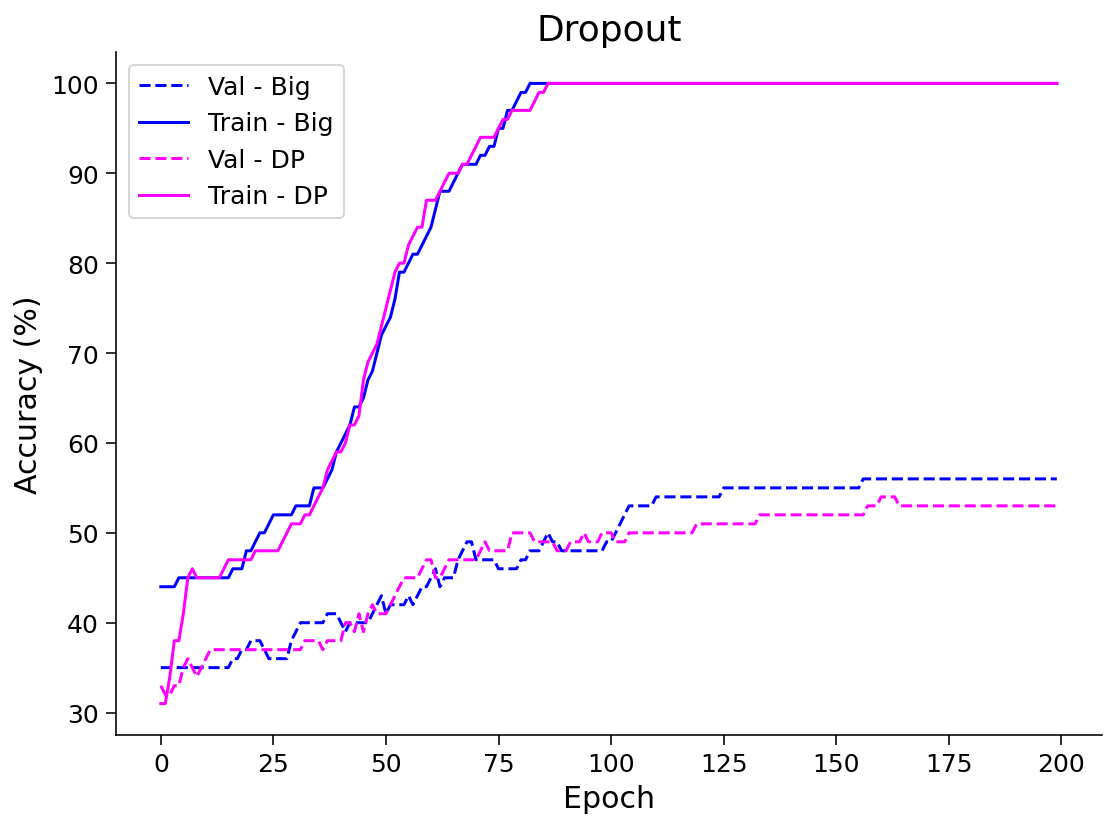

In [33]:
# Set the arguments
args = {
    'test_batch_size': 1000,
    'epochs': 200,
    'lr': 5e-3,
    'batch_size': 32,
    'momentum': 0.9,
    'device': DEVICE,
    'log_interval': 100
}

# intialize the model
set_seed(seed=SEED)
model = AnimalNetDropout()

# Train the model with Dropout
val_acc_dropout, train_acc_dropout, _, model_dp = main(args,
                                                       model,
                                                       train_loader,
                                                       val_loader,
                                                       img_test_dataset)

# intialize the BigAnimalNet model
set_seed(seed=SEED)
model = BigAnimalNet()

# Train the model
val_acc_big, train_acc_big, _, model_big = main(args,
                                                model,
                                                train_loader,
                                                val_loader,
                                                img_test_dataset)


# Train and Test accuracy plot
plt.figure()
plt.plot(val_acc_big, label='Val - Big', c='blue', ls='dashed')
plt.plot(train_acc_big, label='Train - Big', c='blue', ls='solid')
plt.plot(val_acc_dropout, label='Val - DP', c='magenta', ls='dashed')
plt.plot(train_acc_dropout, label='Train - DP', c='magenta', ls='solid')
plt.title('Dropout')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

When do you think dropouts can perform bad and do you think their placement within a model matters?

---
# Section 3: Data Augmentation

*Time estimate: ~15 mins*


In [34]:
# @title Video 3: Data Augmentation
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Xw411d7Pz", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"nm44FhjL3xc", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 3: Data Augmentation')

display(out)

Data augmentation is often used to increase the number of training samples. Now we will explore the effects of data augmentation on regularization. Here regularization is achieved by adding noise into training data after every epoch.

PyTorch's torchvision module provides a few built-in data augmentation techniques, which we can use on image datasets. Some of the techniques we most frequently use are:

* Random Crop
* Random Rotate
* Vertical Flip
* Horizontal Flip


In [35]:
# @markdown ####  Data Loader without Data Augmentation

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)


train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)

# Splitting dataset
img_train_data, img_val_data,_ = torch.utils.data.random_split(img_dataset, [250,100,14280])

# Creating train_loader and Val_loader
train_loader = torch.utils.data.DataLoader(img_train_data,
                                           batch_size=batch_size,
                                           num_workers=2,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
val_loader = torch.utils.data.DataLoader(img_val_data,
                                         batch_size=1000,
                                         num_workers=2,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

Define a DataLoader using `torchvision.transforms`, which randomly augments the data for us. For more info, see [here](https://pytorch.org/vision/stable/transforms.html).

In [36]:
# Data Augmentation using transforms
new_transforms = transforms.Compose([
                                     transforms.RandomHorizontalFlip(p=0.1),
                                     transforms.RandomVerticalFlip(p=0.1),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5),
                                                          (0.5, 0.5, 0.5))
                                     ])

data_path = pathlib.Path('.')/'afhq'  # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=new_transforms)
# Splitting dataset
new_train_data, _,_ = torch.utils.data.random_split(img_dataset,
                                                    [250, 100, 14280])

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Creating train_loader and Val_loader
new_train_loader = torch.utils.data.DataLoader(new_train_data,
                                               batch_size=batch_size,
                                               worker_init_fn=seed_worker,
                                               generator=g_seed)

Random seed 2021 has been set.


  0%|          | 0/250 [00:00<?, ?it/s]

Random seed 2021 has been set.


  0%|          | 0/250 [00:00<?, ?it/s]

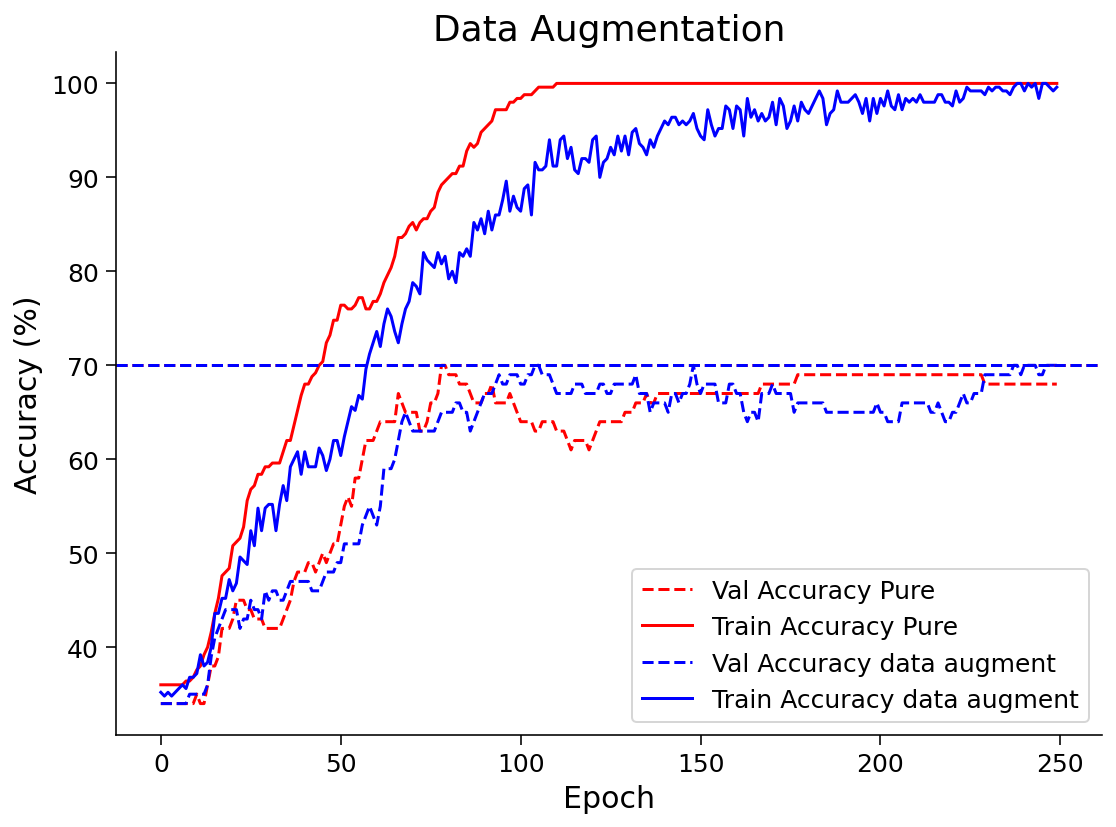

In [37]:
# Set the arguments
args = {
    'epochs': 250,
    'lr': 1e-3,
    'momentum': 0.99,
    'device': DEVICE,
}

# Intialize the model
set_seed(seed=SEED)
model_aug = AnimalNet()

# train the model
val_acc_dataaug, train_acc_dataaug, param_norm_dataaug, _ = main(args,
                                                                 model_aug,
                                                                 new_train_loader,
                                                                 val_loader,
                                                                 img_test_dataset)
# Intialize the model
set_seed(seed=SEED)
model_pure = AnimalNet()

val_acc_pure, train_acc_pure, param_norm_pure, _, = main(args,
                                                         model_pure,
                                                         train_loader,
                                                         val_loader,
                                                         img_test_dataset)


# Train and Test accuracy plot
plt.figure()
plt.plot(val_acc_pure, label='Val Accuracy Pure',
         c='red', ls='dashed')
plt.plot(train_acc_pure, label='Train Accuracy Pure',
         c='red', ls='solid')
plt.plot(val_acc_dataaug, label='Val Accuracy data augment',
         c='blue', ls='dashed')
plt.plot(train_acc_dataaug, label='Train Accuracy data augment',
         c='blue', ls='solid')
plt.axhline(y=max(val_acc_pure), c='red', ls='dashed')
plt.axhline(y=max(val_acc_dataaug), c='blue', ls='dashed')
plt.title('Data Augmentation')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

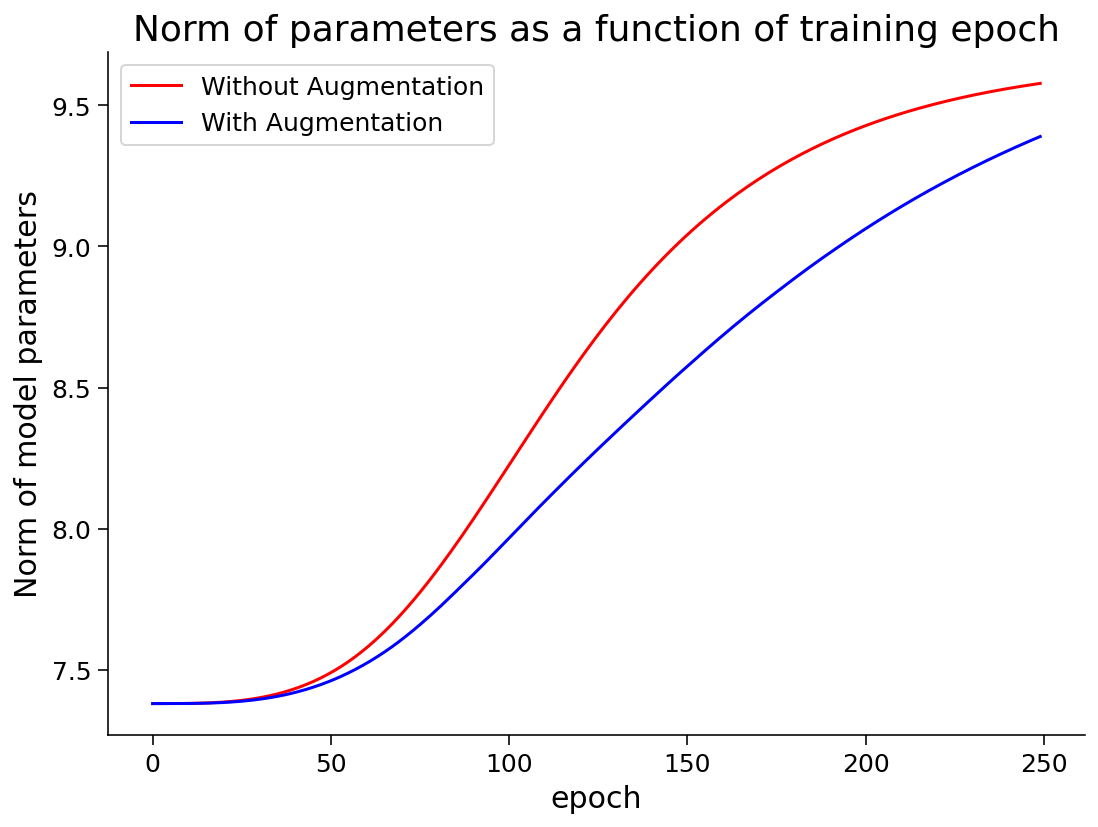

In [38]:
# Plot together: without and with augmenetation
plt.figure()
plt.plot(param_norm_pure, c='red', label='Without Augmentation')
plt.plot(param_norm_dataaug, c='blue', label='With Augmentation')
plt.title('Norm of parameters as a function of training epoch')
plt.xlabel('epoch')
plt.ylabel('Norm of model parameters')
plt.legend()
plt.show()

Can you think of more ways of augmenting the training data? (Think of other problems beyond object recogition.)

### Think! 3.1: Thought Question

Why is it better to regularize an overparameterized ANN than to start with a smaller one? Think about the regularization methods you know.
Each group should have a 10 min discussion.

In [39]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [40]:
# to_remove explanation

"""
Regularization works by penalizing model complexity. If the initial model is not
complex enough to correctly describe the data then no amount of regularization
will help as the model needs to get more complex to improve, not less.
""";

---
# Section 4: Stochastic Gradient Descent

*Time estimate: ~20 mins*

In [41]:
# @title Video 4: SGD
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1nM4y1K7wP", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"rjzlFvJhNqE", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 4: SGD')

display(out)

## Section 4.1: Learning Rate

In this section, we will see how the learning rate can act as a regularizer while training a neural network. In summary:

* Smaller learning rates regularize less and slowly converge to deep minima. 
* Larger learning rates regularize more by missing local minima and converging to broader, flatter minima, which often generalize better.

But beware, a very large learning rate may result in overshooting or finding a bad local minimum.

In the block below, we will train the `AnimalNet` model with different learning rates and see how that affects the regularization.

In [42]:
# @markdown #### Generating Data Loaders

# For reproducibility
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 128
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_dataset = ImageFolder(data_path/'train', transform=train_transform)
img_train_data, img_val_data, = torch.utils.data.random_split(img_dataset, [11700,2930])

full_train_loader = torch.utils.data.DataLoader(img_train_data,
                                                batch_size=batch_size,
                                                num_workers=2,
                                                worker_init_fn=seed_worker,
                                                generator=g_seed)
full_val_loader = torch.utils.data.DataLoader(img_val_data,
                                              batch_size=1000,
                                              num_workers=2,
                                              worker_init_fn=seed_worker,
                                              generator=g_seed)

test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # [TO-DO]
     ])
img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)
# img_test_loader = DataLoader(img_test_dataset, batch_size=batch_size,shuffle=False, num_workers=1)
classes = ('cat', 'dog', 'wild')

In [43]:
# Set the arguments
args = {
    'test_batch_size': 1000,
    'epochs': 350,
    'batch_size': 32,
    'momentum': 0.99,
    'device': DEVICE
}

learning_rates = [5e-4, 1e-3, 5e-3]
acc_dict = {}

for i, lr in enumerate(learning_rates):
  # Initialize the model
  set_seed(seed=SEED)
  model = AnimalNet()
  # Learning rate
  args['lr'] = lr
  # Train the model
  val_acc, train_acc, param_norm, _ = main(args,
                                           model,
                                           train_loader,
                                           val_loader,
                                           img_test_dataset)
  # store the outputs
  acc_dict[f'val_{i}'] = val_acc
  acc_dict[f'train_{i}'] = train_acc
  acc_dict[f'param_norm_{i}'] = param_norm

Random seed 2021 has been set.


  0%|          | 0/350 [00:00<?, ?it/s]

Random seed 2021 has been set.


  0%|          | 0/350 [00:00<?, ?it/s]

Random seed 2021 has been set.


  0%|          | 0/350 [00:00<?, ?it/s]

Maximum Test Accuracy obtained with lr=5.0e-04: 69.0
Maximum Test Accuracy obtained with lr=1.0e-03: 70.0
Maximum Test Accuracy obtained with lr=5.0e-03: 70.0


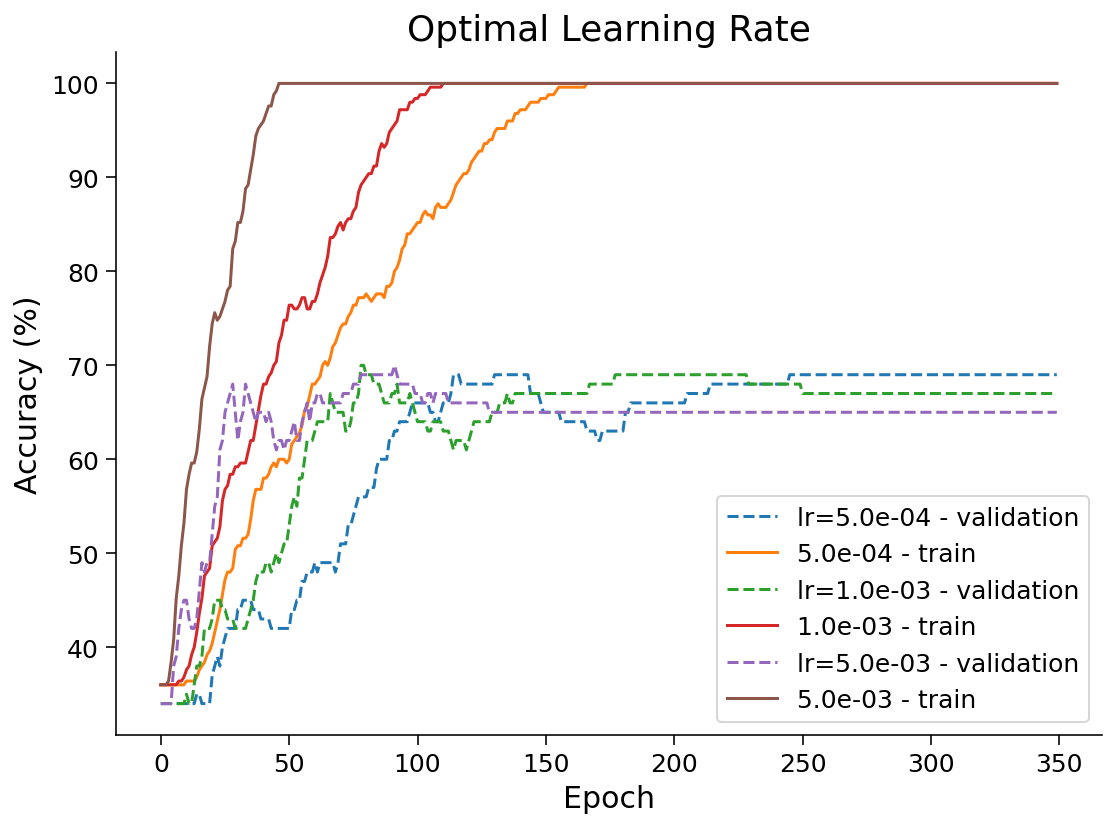

In [44]:
# @markdown Plot Train and Validation accuracy (Run me)

plt.figure()
for i, lr in enumerate(learning_rates):
  plt.plot(acc_dict[f'val_{i}'], linestyle='dashed',
          label=f'lr={lr:0.1e} - validation')
  plt.plot(acc_dict[f'train_{i}'], label=f'{lr:0.1e} - train')

  print(f"Maximum Test Accuracy obtained with lr={lr:0.1e}: {max(acc_dict[f'val_{i}'])}")

plt.title('Optimal Learning Rate')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

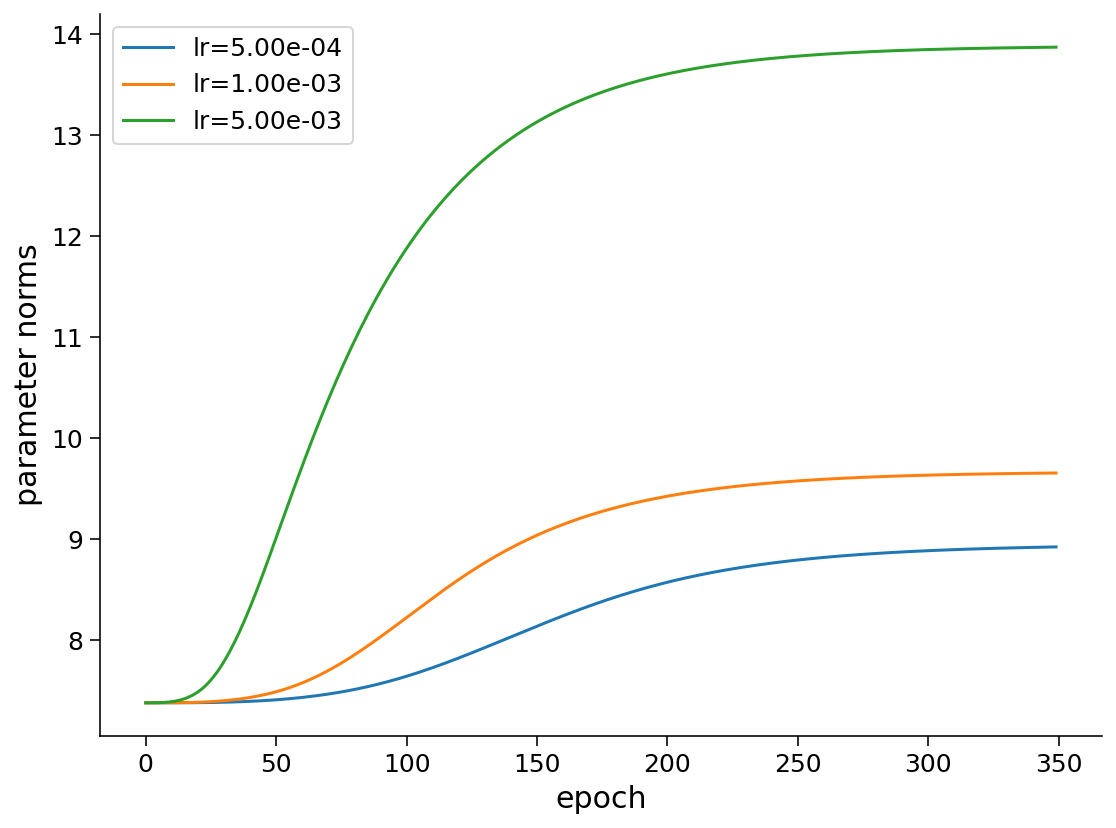

In [45]:
# @markdown Plot parametric norms (Run me)
plt.figure()

for i, lr in enumerate(learning_rates):
  plt.plot(acc_dict[f'param_norm_{i}'],label=f'lr={lr:0.2e}')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('parameter norms')
plt.show()

In the model above, we observe something different from what we expected. Why do you think this is happening?

---
# Section 5: Hyperparameter Tuning

*Time estimate: ~5 mins*


In [46]:
# @title Video 5: Hyperparameter tuning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1E44y127Sn", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"HgkiKRYc-3A", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 5: Hyperparameter tuning')

display(out)

Hyperparameter tuning is often tricky and time-consuming, and it is a vital part of training any Deep Learning model to give good generalization. There are a few techniques that we can use to guide us during the search. 

* **Grid Search**: Try all possible combinations of hyperparameters
* **Random Search**: Randomly try different combinations of hyperparameters
* **Coordinate-wise Gradient Descent**: Start at one set of hyperparameters and try changing one at a time, accept any changes that reduce your validation error
* **Bayesian Optimization / Auto ML**:  Start from a set of hyperparameters that have worked well on a similar problem, and then do some sort of local exploration (e.g., gradient descent) from there.

There are many choices, like what range to explore over, which parameter to optimize first, etc. Some hyperparameters don’t matter much (people use a dropout of either 0.5 or 0.2, but not much else). Others can matter a lot more (e.g., size and depth of the neural net). The key is to see what worked on similar problems.

One can automate the process of tuning the network architecture using the so called *Neural Architecture Search (NAS)*. NAS designs new architectures using a few building blocks (Linear, Convolutional, Convolution Layers, etc.) and optimizes the design based on performance using a wide range of techniques such as Grid Search, Reinforcement Learning, Gradient Descent, Evolutionary Algorithms, etc. This obviously requires very high computing power. Read this [article](https://lilianweng.github.io/lil-log/2020/08/06/neural-architecture-search.html) to learn more about NAS.

## Think! 5: Overview of regularization techniques

Which regularization technique today do you think had the most significant effect on the network? Why might do you think so? Can you apply all of the regularization methods on the same network?

In [47]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q2', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [48]:
# to_remove explanation

"""
Theoretically yes, we can apply all of the regularization methods on the same network.
""";

---
# Summary

Congratulations! You have finished the first week of NMA-DL! 

In this tutorial, you learned more regularization techniques, i.e., L1 and L2 regularization, Dropout, and Data Augmentation. Finally, you have seen that the learning rate of SGD can act as a regularizer. An interesting paper can be found [here](https://arxiv.org/abs/1611.03530). 

Continue to the Bonus material on *Adversarial Attacks*if you have time left!

In [49]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/SurveyButton.png?raw=1"
 alt="button link end of day Survey" style="width:410px"></a>
   </div>""" )

---
# Bonus: Adversarial  Attacks

*Time estimate: ~15 mins*

In [50]:
# @title Video 6: Adversarial Attacks
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV19o4y1X74u", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"LzPPoiKi5jE", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 6: Adversarial Attacks')

display(out)

Designing perturbations to the input data to trick a machine learning model is called an "adversarial attack". These attacks are an inevitable consequence of learning in high dimensional space using complex decision boundaries. Depending on the application, these attacks can be very dangerous.

<br>

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/static/AdversarialAttacks_w1d5t2.png">

<br>

Hence, we need to build models which can defend against such attacks. One possible way to do it is by regularizing the networks, which smooths the decision boundaries. A few ways of building models robust to such attacks are:
* [Defensive Distillation](https://deepai.org/machine-learning-glossary-and-terms/defensive-distillation): Models trained via distillation are less prone to such attacks as they are trained on soft labels as there is an element of randomness in the training process.
* [Feature Squeezing](https://evademl.org/squeezing/): Identifies adversarial attacks for online classifiers whose model is being used by comparing the model's prediction before and after squeezing the input. 
* [SGD](https://arxiv.org/abs/1706.06083): You can also pick weight to minimize what the adversary is trying to maximize via SGD.

<br>

Read more about adversarial attacks [here](https://openai.com/blog/adversarial-example-research/).